In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# constants
data_src = "data/cleaned/tournament_results_short_formatted.csv"

In [3]:
# load data
tournament_results = pd.read_csv(data_src)

In [4]:
# some constants for later use
groups = list(set(tournament_results['player_names']))
groups.sort(key=lambda x: int(x.split(' ')[-1]))

maps = list(set(tournament_results['map']))

In [5]:
tournament_results.head()

,player_names,map,skills,scores,player_states,penalties,timeout_count,error_count,total_time_sorted
0,Group 10,maps/g4/n.json,10,10,1,0,0,1,0.038419
1,Group 10,maps/g4/n.json,10,10,1,0,0,1,0.038422
2,Group 10,maps/g4/n.json,10,10,1,0,0,1,0.037853
3,Group 10,maps/g4/n.json,10,10,1,0,0,1,0.037846
4,Group 10,maps/g4/n.json,10,10,1,0,0,1,0.034455


## Timeout Statistics

- total number of timeouts by group
- total number of timeouts by skill level for each group

In [6]:
total_timeouts_by_group = tournament_results.filter(['player_names', 'timeout_count']).groupby(['player_names']).sum()
total_timeouts_by_group_and_skill_level = tournament_results.filter(['player_names', 'skills', 'timeout_count']).groupby(['skills', 'player_names']).sum()

In [7]:
print(total_timeouts_by_group_and_skill_level.head())

                     timeout_count
skills player_names               
10     Group 1                  46
       Group 10                 12
       Group 2                  51
       Group 3                   0
       Group 4                  63


<AxesSubplot:xlabel='skills'>

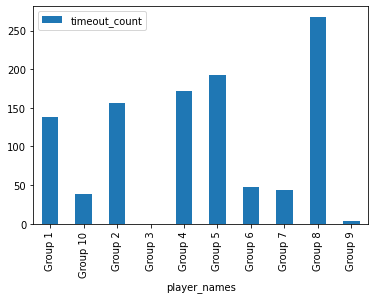

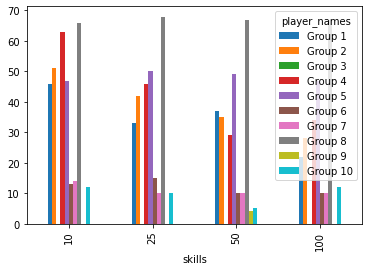

In [8]:
total_timeouts_by_group.plot.bar()

timeouts_df = total_timeouts_by_group_and_skill_level.reset_index().pivot(index='skills', columns='player_names', values='timeout_count').reset_index()
timeouts_df.plot.bar(x='skills', y=groups)

## Penalty Statistics

- penalties per attempt over all skills
- penalties per attempt for each skill

In [9]:
total_penalties_by_group = tournament_results.filter(['player_names', 'penalties']).groupby(['player_names']).sum()
total_penalties_by_group_and_skill_level = tournament_results.filter(['player_names', 'skills', 'penalties']).groupby(['skills', 'player_names']).sum()

If a player times out, it might not have made any moves. Thus, a player who times out often will likely to have fewer penalties.

To remove the effect of timeouts in our penalty frequency analysis, we adjust the total number of penalties by dividing it over the total games attempted by each player.

Here we calculate some aggregate statistics:
- total number of games attempted by each group's player
- total number of games attempted by each group's player broken down by skill level

In [10]:
total_games_played_by_group = tournament_results.filter(['player_names', 'scores']).groupby(['player_names']).count()
total_games_played_by_group_and_skill_level = tournament_results.filter(['player_names', 'skills', 'scores']).groupby(['skills', 'player_names']).count()


total_games_attempted_by_group = tournament_results.filter(['player_names', 'timeouts']).groupby(['player_names'], group_keys=False).apply(lambda x: 1 - x)
total_games_attempted_by_group_and_skill_level = tournament_results.filter(['player_names', 'skills', 'timeouts']).groupby(['skills', 'player_names']).apply(lambda x: 1 - x)

# print(total_games_attempted_by_group)
# print(total_games_attempted_by_group_and_skill_level.head(20))
game_played_stats = total_games_played_by_group.merge(total_timeouts_by_group, on='player_names', copy=False)
game_played_stats = game_played_stats.rename(columns={"scores": "total", "timeout_count": "timeouts"})
game_played_stats = game_played_stats.assign(attempted=lambda x: x.total - x.timeouts)


game_played_stats_by_skill = total_games_played_by_group_and_skill_level.merge(total_timeouts_by_group_and_skill_level, on=['skills', 'player_names'], copy=False)
game_played_stats_by_skill = game_played_stats_by_skill.rename(columns={"scores": "total", "timeout_count": "timeouts"})
game_played_stats_by_skill = game_played_stats_by_skill.assign(attempted=lambda x: x.total - x.timeouts)

# print(game_played_stats)
# print(game_played_stats_by_skill)

Now we calculate the number of penalties per attempt (by skill level):

In [11]:
total_penalties_per_attempt = game_played_stats.merge(total_penalties_by_group, on="player_names", copy=False).assign(penalties_per_attempt=lambda x: x.penalties/x.attempted)
total_penalties_per_attempt_by_skill = game_played_stats_by_skill.merge(total_penalties_by_group_and_skill_level, on=["skills", "player_names"], copy=False).assign(penalties_per_attempt=lambda x: x.penalties/x.attempted)

In [12]:
total_penalties_per_attempt = total_penalties_per_attempt.filter(['player_names', 'penalties_per_attempt'])
total_penalties_per_attempt_by_skill = total_penalties_per_attempt_by_skill.filter(['skills', 'player_names', 'penalties_per_attempt'])

Plotting the graphs...

<AxesSubplot:xlabel='skills'>

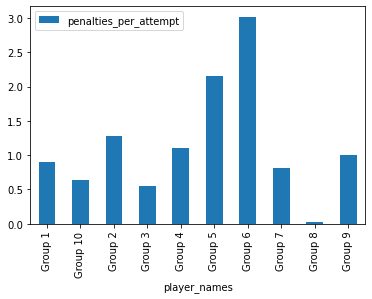

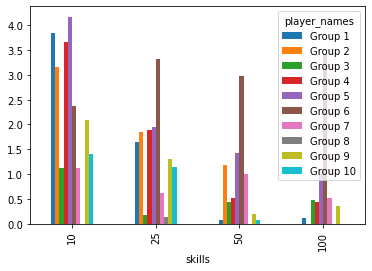

In [13]:
total_penalties_per_attempt.reset_index().plot.bar(x='player_names', y='penalties_per_attempt')

df_penalties_by_skill = total_penalties_per_attempt_by_skill.reset_index().pivot(index='skills', columns='player_names', values='penalties_per_attempt').reset_index()
df_penalties_by_skill.plot.bar(x='skills', y=groups)

## Scores

We are interested in two metrics:

- average score for different skill levels

In [14]:
# 1. group by: player_names, skills
avg_scores_by_group = avg_scores_by_skill_level_and_group = tournament_results.filter(['player_names', 'scores']).groupby(['player_names']).mean()
avg_scores_by_skill_level_and_group = tournament_results.filter(['player_names', 'skills', 'scores']).groupby(['skills', 'player_names']).mean()

<AxesSubplot:xlabel='skills'>

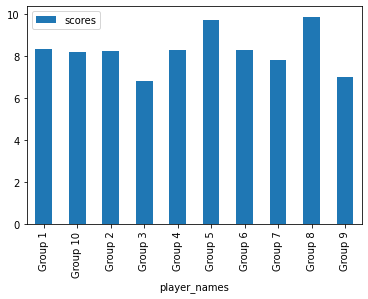

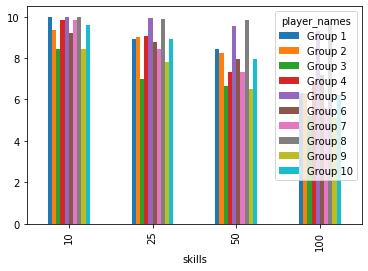

In [15]:
# print(avg_scores_by_skill_level_and_group.tail(20))
# print(avg_scores_by_group)

avg_scores_by_group.reset_index().plot.bar(x="player_names", y="scores")

scores_by_skill_df = avg_scores_by_skill_level_and_group.reset_index().pivot(index="skills", columns="player_names", values="scores").reset_index()
scores_by_skill_df.plot.bar(x="skills", y=groups)

Let's calculate some per map statistics:

- average score by group
- average score by skill and group

In [16]:
base_df = tournament_results.filter(['player_names', 'map', 'skills', 'scores'])
avg_scores_by_map = base_df.filter(['player_names', 'map', 'scores']).groupby(['map', 'player_names']).mean()
avg_scores_by_map_skill = base_df.groupby(['map', 'skills', 'player_names']).mean()

<AxesSubplot:xlabel='map'>

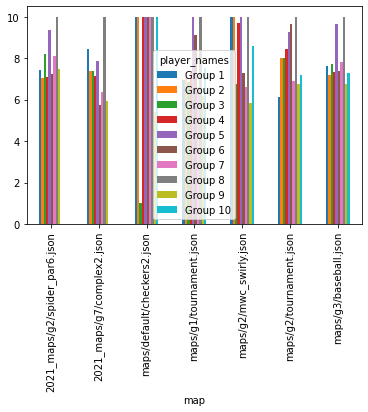

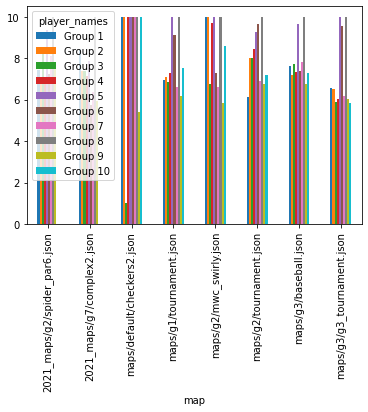

In [17]:
# print(avg_scores_by_map)
# print(avg_scores_by_map_skill)

avg_scores_map_df = avg_scores_by_map.reset_index().pivot(index='map', columns='player_names', values='scores').reset_index()
total_maps = len(avg_scores_map_df.index)
hd, tl = math.floor(total_maps/2), math.ceil(total_maps/2)

avg_scores_map_df.head(hd).plot.bar(x='map', y=groups)
avg_scores_map_df.head(tl).plot.bar(x='map', y=groups)

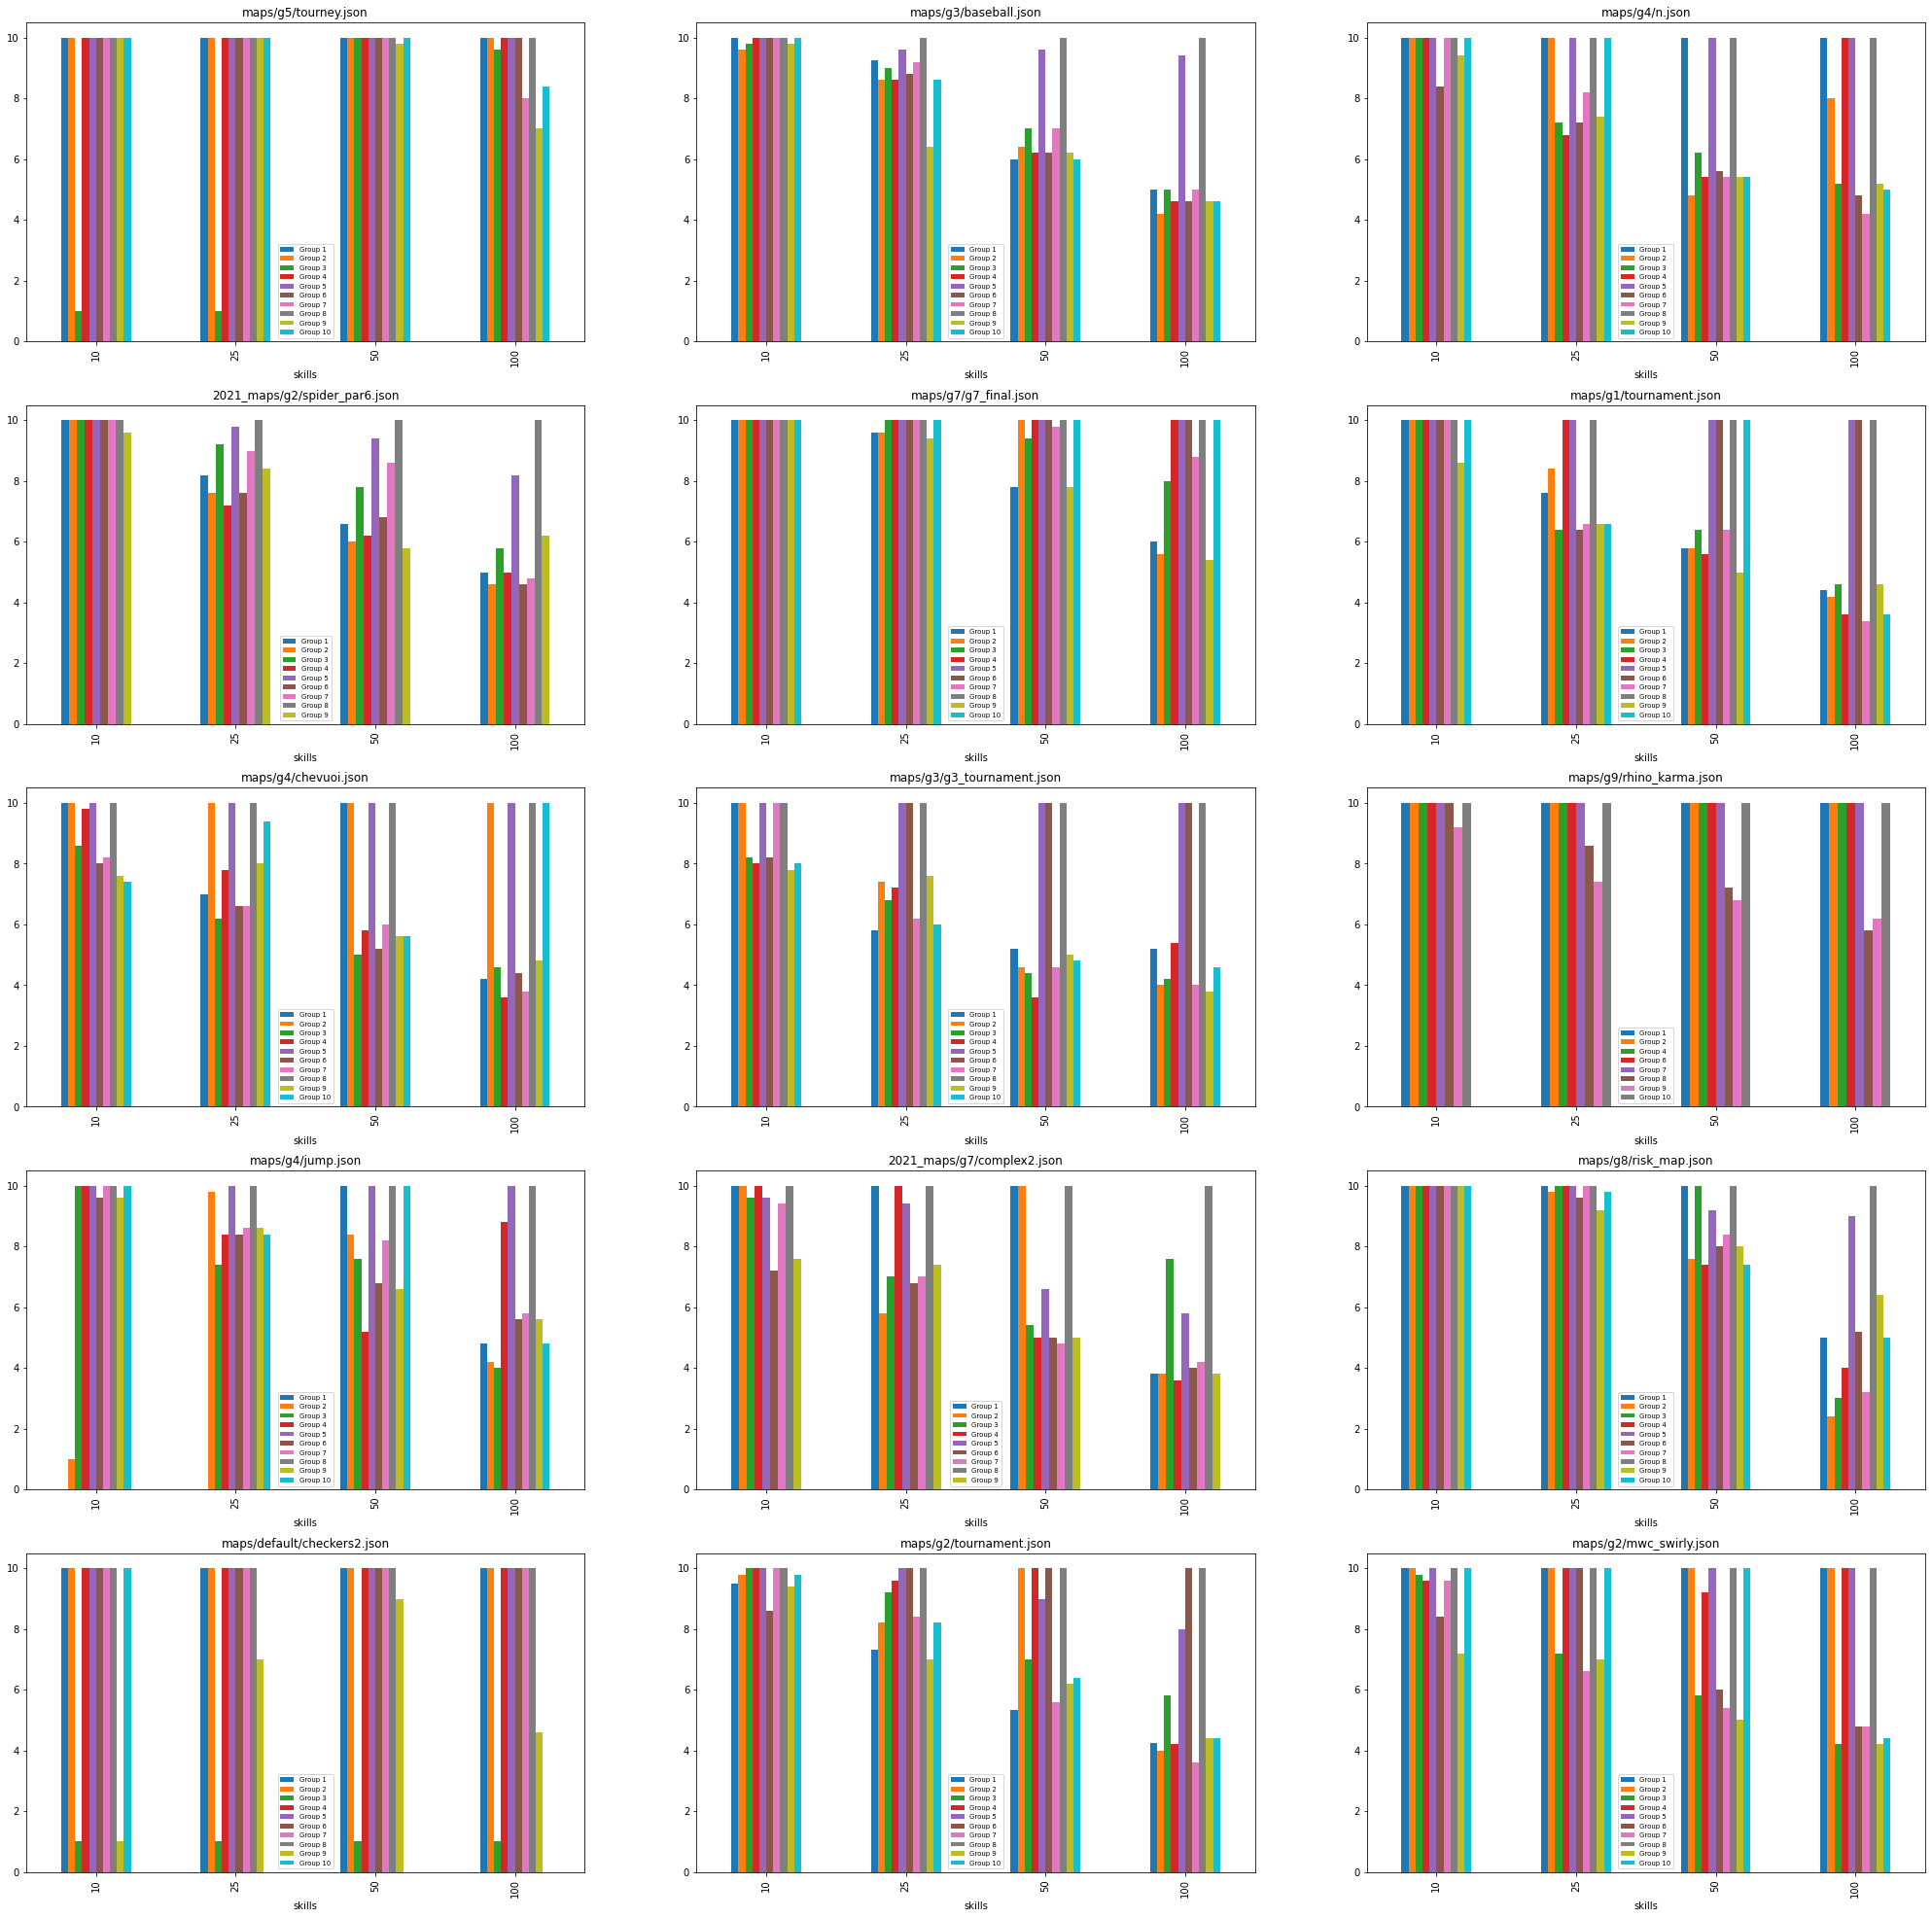

In [18]:
avg_scores_map_skill_df = avg_scores_by_map_skill.reset_index()

nrow, ncol = 5, 3
map_fig, map_axes = plt.subplots(nrow, ncol, figsize=(35, 35))

count = 0
for tmap in maps:
	map_df = avg_scores_map_skill_df[avg_scores_map_skill_df['map'] == tmap]
	map_groups = list(set(map_df['player_names'].values.tolist()))
	map_groups.sort(key=lambda x: int(x.split(' ')[-1]))

	map_df = map_df.pivot(index='skills', columns='player_names', values='scores').reset_index()
	map_df.plot.bar(x='skills', y=map_groups, title=tmap, ax=map_axes[count // ncol, count % ncol])
	map_axes[count // ncol, count % ncol].legend(loc='best', fontsize='x-small')
	count += 1